<a href="https://colab.research.google.com/github/magical-to/2025_ASW/blob/main/Colab_%EC%8B%9C%EC%9E%91%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 새 섹션

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), # 16 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1), # 32 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3,padding=1), # 64 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2) # 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), # 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,padding=1), # 256 x 7 x 7
            nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(x.size(0), -1)
        return out

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,2,1,1), # 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,64,3,1,1), # 64 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64,16,3,1,1), # 16 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,3,2,1,1), # 1 x 28 x 28
            nn.ReLU()
        )

    def forward(self,x):
        out = x.view(x.size(0),256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [6]:
mnist_train = dset.MNIST(
    root="./data/MNIST",
    train=True,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True
)

mnist_test = dset.MNIST(
    root="./data/MNIST",
    train=False,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True
)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
    dataset=mnist_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    drop_last=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 62.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.83MB/s]


In [7]:
# 하이퍼파라미터 및 모델 설정
num_epoch = 10
learning_rate = 0.0002

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 인스턴스 생성 및 장치 할당
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 옵티마이저를 위한 파라미터 묶기
parameters = itertools.chain(encoder.parameters(), decoder.parameters())

# 손실 함수 및 옵티마이저 정의
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)


Final Test Loss (one batch): 0.7661

Original Image vs. Reconstructed Image


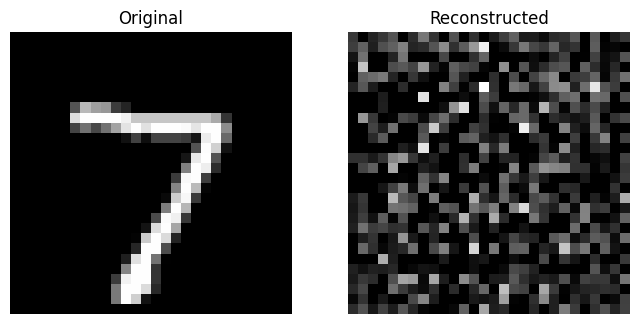

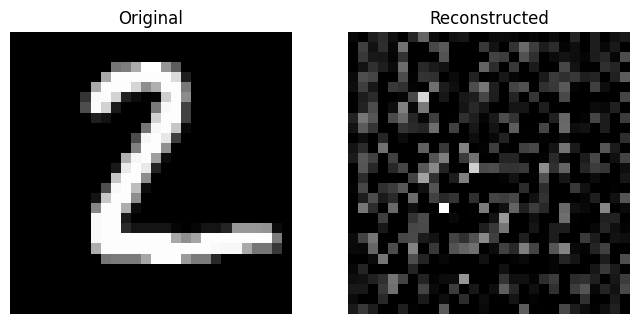

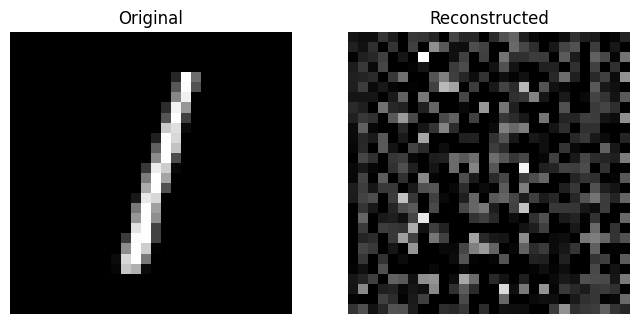

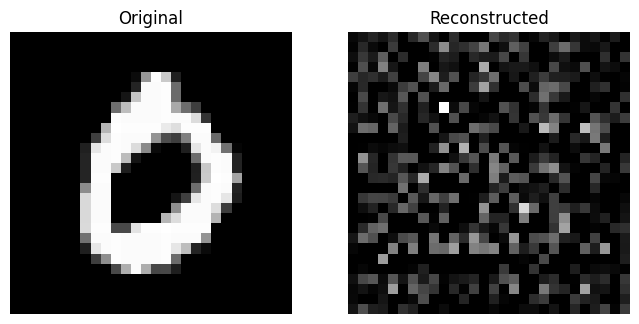

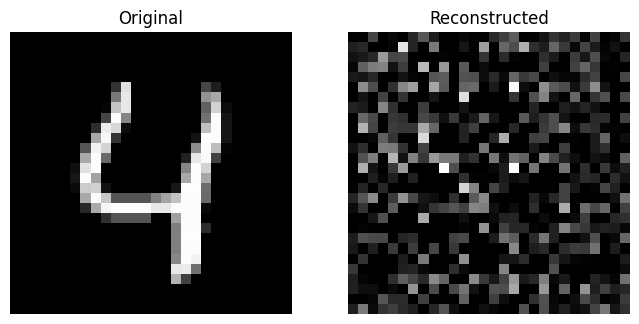

In [8]:
# 7. 훈련 후 테스트 및 결과 시각화 (개선된 버전)

# 기울기 계산을 비활성화하여 리소스를 아낍니다.
with torch.no_grad():
    # 테스트 로더에서 이미지 한 배치를 가져옵니다.
    test_iter = iter(test_loader)
    image, label = next(test_iter)

    # 모델에 이미지를 통과시킵니다.
    image = image.to(device)
    z = encoder(image)
    output = decoder(z)

    # 최종 손실을 확인합니다.
    loss = loss_func(output, image)
    print(f"\nFinal Test Loss (one batch): {loss.item():.4f}")

    # 결과를 시각화하기 위해 cpu로 데이터를 옮깁니다.
    out_img = torch.squeeze(output.cpu())
    in_img = torch.squeeze(image.cpu())

    print("\nOriginal Image vs. Reconstructed Image")
    # 5개의 이미지를 비교하여 출력
    for i in range(5):
        plt.figure(figsize=(8, 4)) # 전체 그림 크기 조절

        # 원본 이미지 출력 (1행 2열 중 첫 번째)
        ax1 = plt.subplot(1, 2, 1)
        ax1.set_title("Original")
        ax1.imshow(in_img[i], cmap='gray')
        ax1.axis('off') # 축 번호 숨기기

        # 재구성된 이미지 출력 (1행 2열 중 두 번째)
        ax2 = plt.subplot(1, 2, 2)
        ax2.set_title("Reconstructed")
        ax2.imshow(out_img[i], cmap='gray')
        ax2.axis('off') # 축 번호 숨기기

        plt.show()

In [9]:
# 6. 훈련 루프
print("\n===== Start Training =====")
for i in range(num_epoch):
    epoch_loss = 0.0

    for j, [image, label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)

        z = encoder(image)
        output = decoder(z)

        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{i+1}/{num_epoch}], Average Loss: {avg_loss:.4f}")

print("\n===== Training Finished! =====")


===== Start Training =====
Epoch [1/10], Average Loss: 0.0192
Epoch [2/10], Average Loss: 0.0035
Epoch [3/10], Average Loss: 0.0025
Epoch [4/10], Average Loss: 0.0020
Epoch [5/10], Average Loss: 0.0017
Epoch [6/10], Average Loss: 0.0015
Epoch [7/10], Average Loss: 0.0013
Epoch [8/10], Average Loss: 0.0012
Epoch [9/10], Average Loss: 0.0010
Epoch [10/10], Average Loss: 0.0009

===== Training Finished! =====
